In [27]:
%load_ext autoreload
%autoreload 2


from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from sqlalchemy import event, create_engine, select
from sqlalchemy.orm import sessionmaker

from chemicalite_orm.models import Compound, Base
from chemicalite_orm.molecules import SMILES_SAMPLE as mols
from chemicalite_orm.functions import mol_is_substruct, mol_from_smiles


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
DATABASE_URL = "sqlite:///chemicalite.db"

engine = create_engine(DATABASE_URL, echo=True)


@event.listens_for(engine, "connect")
def load_chemicalite(dbapi_conn, connection_record):
    dbapi_conn.enable_load_extension(True)
    dbapi_conn.load_extension("chemicalite")


SessionLocal = sessionmaker(bind=engine)
Base.metadata.create_all(engine)

2025-04-30 00:40:09,644 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-04-30 00:40:09,645 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("compound")
2025-04-30 00:40:09,646 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-04-30 00:40:09,648 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("compound")
2025-04-30 00:40:09,648 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-04-30 00:40:09,650 INFO sqlalchemy.engine.Engine 
CREATE TABLE compound (
	id INTEGER NOT NULL, 
	name VARCHAR NOT NULL, 
	smiles VARCHAR NOT NULL, 
	molecule mol NOT NULL, 
	PRIMARY KEY (id)
)


2025-04-30 00:40:09,650 INFO sqlalchemy.engine.Engine [no key 0.00063s] ()
2025-04-30 00:40:09,657 INFO sqlalchemy.engine.Engine 
        CREATE VIRTUAL TABLE IF NOT EXISTS str_idx_compound
        USING rdtree(id, fp bits(2048))
    
2025-04-30 00:40:09,657 INFO sqlalchemy.engine.Engine [generated in 0.00068s] ()
2025-04-30 00:40:09,664 INFO sqlalchemy.engine.Engine 
        CREATE VIRTUAL TABLE IF NOT EXISTS si

In [29]:
def smi2mol(smi):
    mol = Chem.MolFromSmiles(smi)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)

    return mol

def insert_test_data():
    with SessionLocal() as session:
        for i, smiles in enumerate(mols):
            compound = Compound(
                name=f"mol_{i}",
                smiles=smiles,
                molecule=smi2mol(smiles),
            )
            session.add(compound)
        session.commit()


insert_test_data()

[00:40:11] UFFTYPER: Unrecognized hybridization for atom: 4
[00:40:11] UFFTYPER: Unrecognized atom type: Cu+1 (4)
[00:40:11] UFFTYPER: Unrecognized hybridization for atom: 4
[00:40:11] UFFTYPER: Unrecognized atom type: Cu+1 (4)


2025-04-30 00:40:12,385 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-04-30 00:40:12,387 INFO sqlalchemy.engine.Engine INSERT INTO compound (name, smiles, molecule) VALUES (?, ?, mol_from_binary_mol(?))
2025-04-30 00:40:12,388 INFO sqlalchemy.engine.Engine [generated in 0.00064s] ('mol_0', 'NN=C(c1ccccc1)c1ccccc1', b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\x1b\x00\x00\x00\x1c\x00\x00\x00\x80\x01\x07\x00(\x00\x00\x00\x03\x0 ... (1927 characters truncated) ... \x05\xa8\xf1\xbfn%\x95\xc0U\xa56>G\x9d\x85\xbf[5\x9f\xc0\x80\xfd|?\xe8S\xa5?\xb2\x83B\xc0\xaa[\xa1?\xdf\xfd,@\xea\xa5Y\xbf\xb2\xea6?\xd0\x04\xf4?\x16')
2025-04-30 00:40:12,389 INFO sqlalchemy.engine.Engine INSERT INTO compound (name, smiles, molecule) VALUES (?, ?, mol_from_binary_mol(?))
2025-04-30 00:40:12,389 INFO sqlalchemy.engine.Engine [cached since 0.002205s ago] ('mol_1', 'COc1ccc(C=NO)cc1', b'\xef\xbe\xad\xde\x00\x00\x00\x00\x10\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\x14\

2025-04-30 00:40:15,800 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-04-30 00:40:15,802 INFO sqlalchemy.engine.Engine SELECT compound.id, compound.name, compound.smiles, mol_to_molblock(compound.molecule) AS molecule 
FROM compound 
WHERE mol_is_substruct(compound.molecule, mol_from_smiles(?))
2025-04-30 00:40:15,803 INFO sqlalchemy.engine.Engine [generated in 0.00117s] ('c1ccccc1',)
2025-04-30 00:40:15,824 INFO sqlalchemy.engine.Engine ROLLBACK


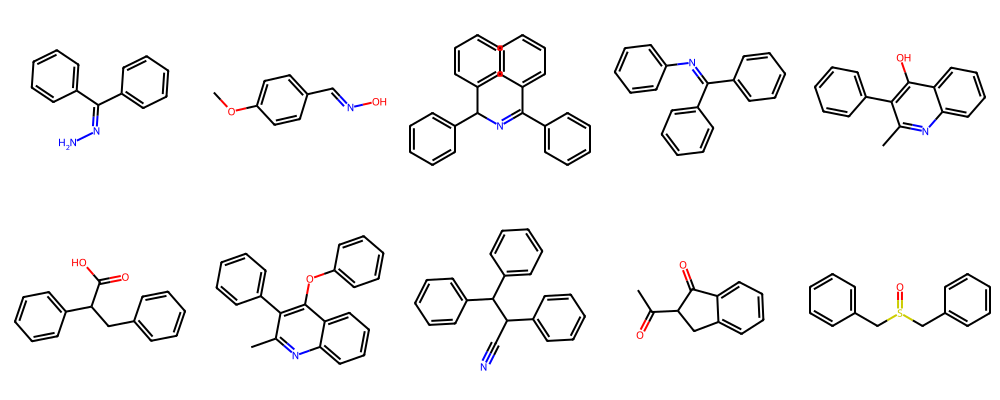

In [30]:
def test_substructure(smarts="c1ccccc1"):
    smis = []

    query_mol = mol_from_smiles(smarts)
    with SessionLocal() as session:
        stmt = select(Compound).where(mol_is_substruct(Compound.molecule, query_mol))
        results = session.execute(stmt).scalars().all()

        for r in results:
            smis.append(r.smiles)
    return smis


smis = test_substructure()
res_mols = [Chem.MolFromSmiles(smi) for smi in smis[:10]]
Draw.MolsToGridImage(res_mols, molsPerRow=5)

2025-04-30 00:40:18,054 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-04-30 00:40:18,055 INFO sqlalchemy.engine.Engine 
            SELECT compound.* FROM compound
            JOIN str_idx_compound ON compound.id = str_idx_compound.id
            WHERE str_idx_compound.id MATCH rdtree_subset(mol_pattern_bfp(mol_from_smiles(?), 2048));
        
2025-04-30 00:40:18,056 INFO sqlalchemy.engine.Engine [generated in 0.00065s] ('c1ccnnc1',)
1
2025-04-30 00:40:18,057 INFO sqlalchemy.engine.Engine ROLLBACK


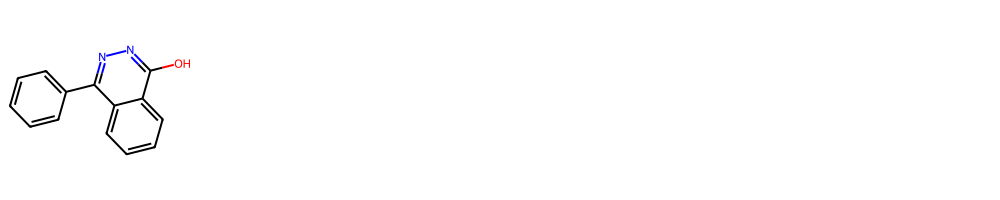

In [31]:
with SessionLocal() as session:
    hits = Compound.search_by_substructure(session, "c1ccnnc1")
    print(len(hits))
    

hit_smis = [hit.smiles for hit in hits]
hit_mols = [Chem.MolFromSmiles(smi) for smi in hit_smis[:10]]
Draw.MolsToGridImage(hit_mols, molsPerRow=5)


2025-04-30 00:40:19,729 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-04-30 00:40:19,730 INFO sqlalchemy.engine.Engine 
            SELECT compound.*, bfp_tanimoto(sim_idx_compound.fp, mol_morgan_bfp(mol_from_smiles(?), 2, 1024)) as sim
            FROM compound
            JOIN sim_idx_compound ON compound.id = sim_idx_compound.id
            WHERE sim >= ?
            ORDER BY sim DESC
        
2025-04-30 00:40:19,731 INFO sqlalchemy.engine.Engine [generated in 0.00066s] ('c1ccnnc1', 0.01)
76
2025-04-30 00:40:19,733 INFO sqlalchemy.engine.Engine ROLLBACK


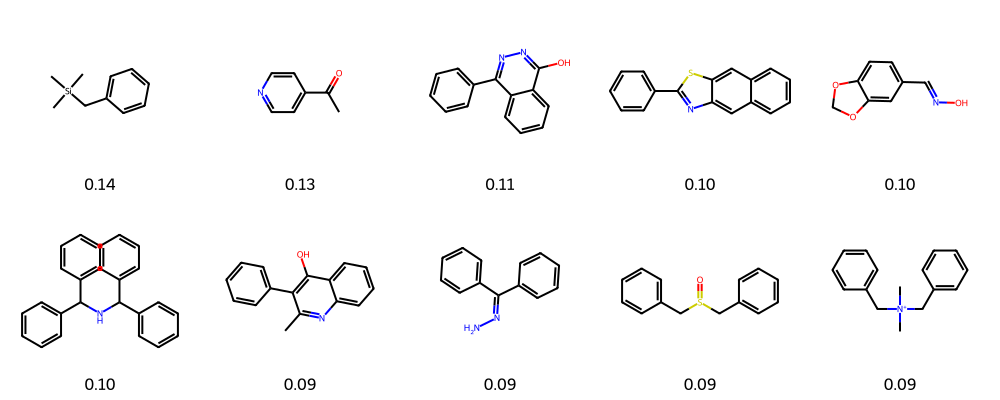

In [32]:
with SessionLocal() as session:
    hits = Compound.search_by_similarity(session, "c1ccnnc1", 0.01)
    print(len(hits))


hit_smis = [hit.smiles for hit in hits[:10]]
hit_mols = [Chem.MolFromSmiles(smi) for smi in hit_smis]
similarity = [hit.sim for hit in hits[:10]]
Draw.MolsToGridImage(
    hit_mols, molsPerRow=5, legends=[f"{s:.2f}" for s in similarity]
)


In [33]:
session = SessionLocal()
stmt = select(Compound)
res = session.execute(stmt).scalars().all()


2025-04-30 00:40:21,821 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-04-30 00:40:21,822 INFO sqlalchemy.engine.Engine SELECT compound.id, compound.name, compound.smiles, mol_to_molblock(compound.molecule) AS molecule 
FROM compound
2025-04-30 00:40:21,823 INFO sqlalchemy.engine.Engine [generated in 0.00069s] ()


In [35]:
type(res[0].molecule)

rdkit.Chem.rdchem.Mol